# Natural Language Intent to Parameterized Function Calls with Phi-3

This notebook explores mapping natural language intent to parameterized function calls with small language models (SLM). This is 
particularly relevant in edge scenarios where latency and/or connectivity issues make the unavailability of cloud-only solutions infeasible.

To make the scenario more concrete, this evaluation considers a use case that has a lot of traction in the automotive industry: 
an an automotive assistant that helps a driver control non-safety critical systems via voice.  It also focuses the investigation around Phi-3 SLM, but also consider other SLMs (in particular Llama3) and different sizes of Phi-3 (in particular small and medium) to compare and contrast the baseline performance of Phi-3 mini with these other SLMs.

Finally, it also considers three different implementation techniques.  Namely, it considers:

1. Llama.cpp (via python wrappers / CUDA accelerated) with direct prompts of the LLM.
2. Llama.cpp (via python wrappers / CUDA accelerated) with [guidance](https://github.com/guidance-ai/guidance) steered LLM generation.
    
There are three main questions this experiment sought to answer:

1. Can Phi-3 accurately map user natural language intents to parameterized function calls? And how does it compare to other SLMs?
2. Can it achieve this with the subsecond latency required for a fluent user experience?
3. How do different backend hosting and implementation techniques affect latency and correctness?

The performance results for this investigation were captured in an WSL2 Ubuntu environment on an AMD 7950X3D desktop PC 
with an Nvidia RTX4080 GPU.  All configurations were configured to use the GPU for acceleration.

This investigation shows that the answers to these questions are:

1. Yes, this is feasible with the simple single intent commands we consider here. Phi-3 mini is able to map intent to the 
   correct function with the correct parameters roughly 99% of the time with 0% incorrect function (but valid function call) mappings
   that cause the most user confusion.
2. With GPU acceleration, Phi-3 to do this mapping consistently (p99) in subsecond time.
3. Implementation matters a great deal. This investigation shows that utilizing LLM steering libraries like guidance can 
   both accelerate performance (4.3x speedup) and improve correctness (91.11% -> 99.89%).

Finally, there are many avenues where this work could be extended:

1. Extending the investigation to look at more complex natural language commands like "Please lower the temperature to 59 and increase the fan" to investigate if SLMs can decode these multiple intents into multiple function calls.
2. How do SLMs perform with the typical recognition errors of a speech to text system?
3. How many tools can SLMs juggle before their correctness starts to decrease dramatically?

Example scenarios:

Can you switch the radio to Radio Bob?
Route me to 10 Kärntner Straße
Take me to 1000 Fifth Avenue, New York
Can you please lock the doors for me.
Could you unlock the doors?
Navigate to 50 Massachusetts Avenue Northeast, Washington, District of Columbia
Would you unlock the doors, please?
Get directions to 100 Oxford Street, London
Would you mind unlocking the doors?
Can you please unlock the doors for me.
Change the radio to 101.7
What's the current temperature setting?
Can you tell me the current temperature setting?
Could you adjust the radio to 102.3 for me?
Would you mind putting it at 75 degrees?
Could you change the temp to 70 degrees?
Please tune to 99.1 on the radio
Please tune to 94.5 on the radio
Please turn the volume to 1
Please text Matthew Wilson that I am on my way
Can you set the temperature to 59 degrees?
Please call Olivia
Please text Amanda Sanders that I am on my way
Could you adjust the radio to 103.1 for me?
Could you unlock the doors?
Set the audio to 8
Turn off fan
Set the temperature to 61 degrees please
Route me to 1 Infinite Loop
Please text Henrik that I am on my way


In [43]:
import json

with open('results/model-eval-amd-7950x3d-rtx4080.json', 'r') as file:
    data = json.load(file)

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

records = []
for model, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'model': model,
            'tool': tool,
            'pass_percentage': metrics['pass_percentage'],
            'median_latency': metrics['median_latency'],
            'latencies': metrics['latencies'],
            'errors': metrics['errors']
        })

df = pd.DataFrame(records)

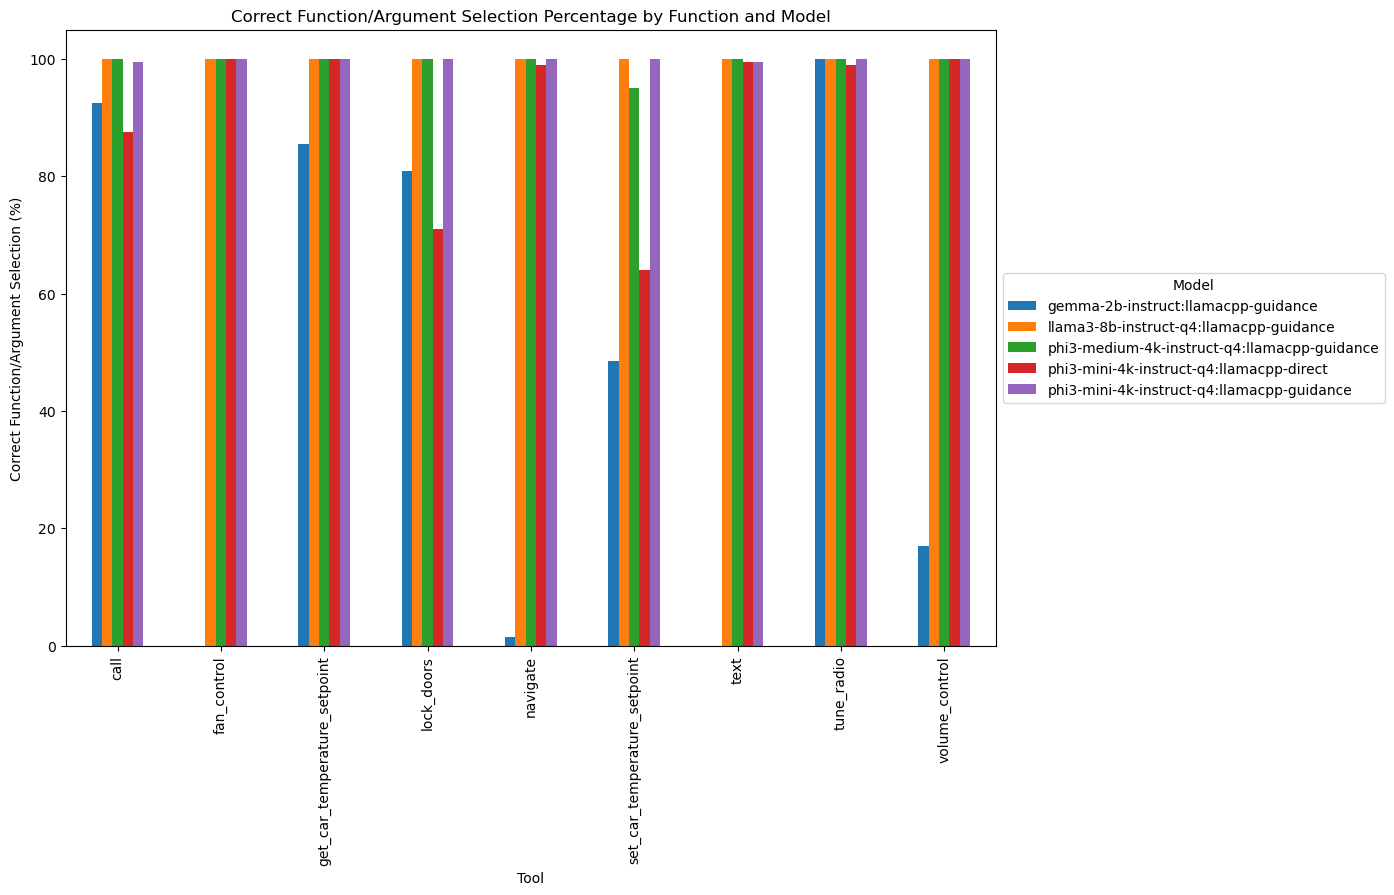

In [34]:

# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Function/Argument Selection Percentage by Function and Model')
plt.xlabel('Tool')
plt.ylabel('Correct Function/Argument Selection (%)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [35]:
from tabulate import tabulate
from IPython.display import display, HTML

def print_results(results):
    headers = ["f(x)", "p", "fi", "pi", "nfr", "i(bvfc)", "total", "%", "min (ms)", "mean", "median", "max (ms)"]

    data = []
    total_count = 0
    passed_count = 0
    total_median_latency = 0.0
    tool_count = 0

    for pivot in results:
        tool_count += 1
        pivot_results = results[pivot]
        if pivot_results["total_evaluations"] > 0:
            passed = pivot_results["passed"]
            function_incorrect = pivot_results["function_incorrect"]
            parameters_incorrect = pivot_results["parameters_incorrect"]
            non_function_response = pivot_results["non_function_response"]
            total_evaluations = pivot_results["total_evaluations"]
            incorrect_but_valid = pivot_results["incorrect_but_valid"]
            pass_percentage = pivot_results["pass_percentage"]

            passed_count += passed
            total_count += total_evaluations
            total_median_latency += pivot_results["median_latency"]

            min_latency = pivot_results["min_latency"]
            max_latency = pivot_results["max_latency"]
            mean_latency = pivot_results["mean_latency"]
            median_latency = pivot_results["median_latency"]

            data.append([pivot, passed, function_incorrect, parameters_incorrect, non_function_response, incorrect_but_valid, total_evaluations, pass_percentage, min_latency, mean_latency, median_latency, max_latency])  

    print(tabulate(data, headers=headers))

    overall_percentage = 100.0 * passed_count / total_count
    overall_median_latency = total_median_latency / tool_count

    print()
    print(f"overall: {passed_count} / {total_count} ({overall_percentage:.2f}%) {overall_median_latency:.2f}ms avg median latency")
    
for config_tag in data:
    display(HTML(f"<b>{config_tag}</b>"))
    print()
    print_results(data[config_tag])
    print()


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)     mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  -------  --------  ----------
call                          199     0     1      0          0      200   99.5     228.642  392.928   366.336     715.983
fan_control                   200     0     0      0          0      200  100       154.156  191.527   189.018     259.842
get_car_temperature_setpoint  200     0     0      0          0      200  100        84.337  138.902   138.795     190.344
lock_doors                    200     0     0      0          0      200  100       162.592  226.069   226.241     313.367
navigate                      200     0     0      0          0      200  100       453.715  878.644   890.813    1372.35
set_car_temperature_setpoint  200     0     0      0          0      200  100       447.82   484.123   478.567     662.313
text            


f(x)                            p    fi    pi    nfr    i(bvfc)    total    %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  ---  ----------  --------  --------  ----------
call                          200     0     0      0          0      200  100     990.124  1473.5    1394.13      2405.82
fan_control                   200     0     0      0          0      200  100     423.265   902.113   897.284     1152.88
get_car_temperature_setpoint  200     0     0      0          0      200  100     606.303   756.547   746.624     1026.23
lock_doors                    200     0     0      0          0      200  100     444.743   999.353   998.555     1230.92
navigate                      200     0     0      0          0      200  100    1703.77   2764.45   2751.83      4069.31
set_car_temperature_setpoint  190     0    10      0          0      200   95    1712.28   1995.47   1999.04      2258.84
text                   


f(x)                            p    fi    pi    nfr    i(bvfc)    total    %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  ---  ----------  --------  --------  ----------
call                          200     0     0      0          0      200  100     702.67    980.011   938.969    1547.85
fan_control                   200     0     0      0          0      200  100     548.072   702.328   695.858     986.809
get_car_temperature_setpoint  200     0     0      0          0      200  100     353.648   500.728   502.244     762.98
lock_doors                    200     0     0      0          0      200  100     597.723   725.965   722.043    1063.65
navigate                      200     0     0      0          0      200  100     958.705  1577.45   1611.6      2424.81
set_car_temperature_setpoint  200     0     0      0          0      200  100     966.214  1107.92   1101.45     1430.83
text                        


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)      mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  --------  --------  ----------
call                          185     0    15      0          0      200   92.5    1198.24   1482.07   1486.34      2520.31
fan_control                     0   200     0      0        200      200    0      1203.38   1483.27   1335.01      2046.05
get_car_temperature_setpoint  171    29     0      0         29      200   85.5     452.267   844.043   736.446     2056.06
lock_doors                    162    38     0      0         38      200   81       985.774  1225.61   1117.64      1839.46
navigate                        3   197     0      0        197      200    1.5     990.58   1951.45   1562.55      5224.58
set_car_temperature_setpoint   97    64    39      0         64      200   48.5     451.245  1807.7    1972.72      4422.71
text   


f(x)                            p    fi    pi    nfr    i(bvfc)    total      %    min (ms)     mean    median    max (ms)
----------------------------  ---  ----  ----  -----  ---------  -------  -----  ----------  -------  --------  ----------
call                          175     0    25      0          0      200   87.5     806.699  1224.96   951.535     3066.52
fan_control                   200     0     0      0          0      200  100      1353.9    1986.1   2210.96      2553.32
get_car_temperature_setpoint  200     0     0      0          0      200  100      1417.27   1852.97  1947.38      2389.96
lock_doors                    142     0     0     58          0      200   71      1014.71   2107.97  2714.98      3012.03
navigate                      198     0     0      2          0      200   99      1133.11   1578.73  1565.69      3774.16
set_car_temperature_setpoint  128     0     0     72          0      200   64      1497.89   2043.44  1568.29     12473.1
text            

This evaluation tested two different implementation approaches. The first was the direct prompting of the LLM via llama.cpp's python bindings and the second was to use llama.cpp in conjunction with the [guidance](https://github.com/guidance-ai/guidance) steering library. Guidance allows you to guide the LLM, specifying "must have" boilerplate in the response, specific options for portions of the response, and regular expressions for acceptable characters in other portions of the response. This both essentially steers the LLM towards valid responses and also accelerates generation, as the LLM does not need to generate the boilerplate portions but instead has those tokens pushed directly into its context.  In the context of function calling, where the goal is to return a JSON document with the function and the parameters, this approach is particularly effective, as the results above show.

For phi3-mini-4k-instruct-q4, the difference between the directly prompting and guidance steered approach boosted correct function mapping from (91.11% to 99.89%) and reduced average median latency from (1852ms to 423ms, -77.18% decrease).

The evaluation also tested four different models: phi3-mini-4k-instruct-q4, phi3-medium-4k-instruct-q4, llama3-8b-instruct-q4, and gemma-2b-instruct-q8. 

llama3-8b-instruct-q4 was the most correct (100%) but also had twice the parameters (resulting in higher GPU requirements, so higher cost) and had a higher latency to results (951ms vs. 428ms, 122% higher).

gemma-2b-instruct was the least correct (47.33%) and also had high latency. I briefly tried gemma-7b-instruct to see if this improved correctness and the latency was so high (order of 60 seconds per scenario) that I abandoned the exercise.

One surprise in the results is that phi3-medium-4k-instruct-q4 was consistently slightly worse in correctness versus phi3-mini-4k-instruct-q4 across runs. I expected it to be slower, but not worse. I don't have a theory to explain this.

Lower in the notebook we enumerate the failures from each configuration. One of the interesting insights from that failure analysis is that one of the weakness of phi3 is that it is not good with non-traditional names in the English language.  For example, this failure:

```
"Please call Steven Ramirez"
expected params:  {'name': 'Steven Ramirez'}
generated params: {'name': 'Steven Ramiree'}
```

shows that perhaps the hispanic name Ramirez does not show up often in the textbooks that were used to train Phi-3.  Likewise, this failure:

```
"Please call Clara Müller"
expected params:  {'name': 'Clara Müller'}
generated params: {'name': 'Clara Muller'}
```

suggests that the training material did not include many German names.

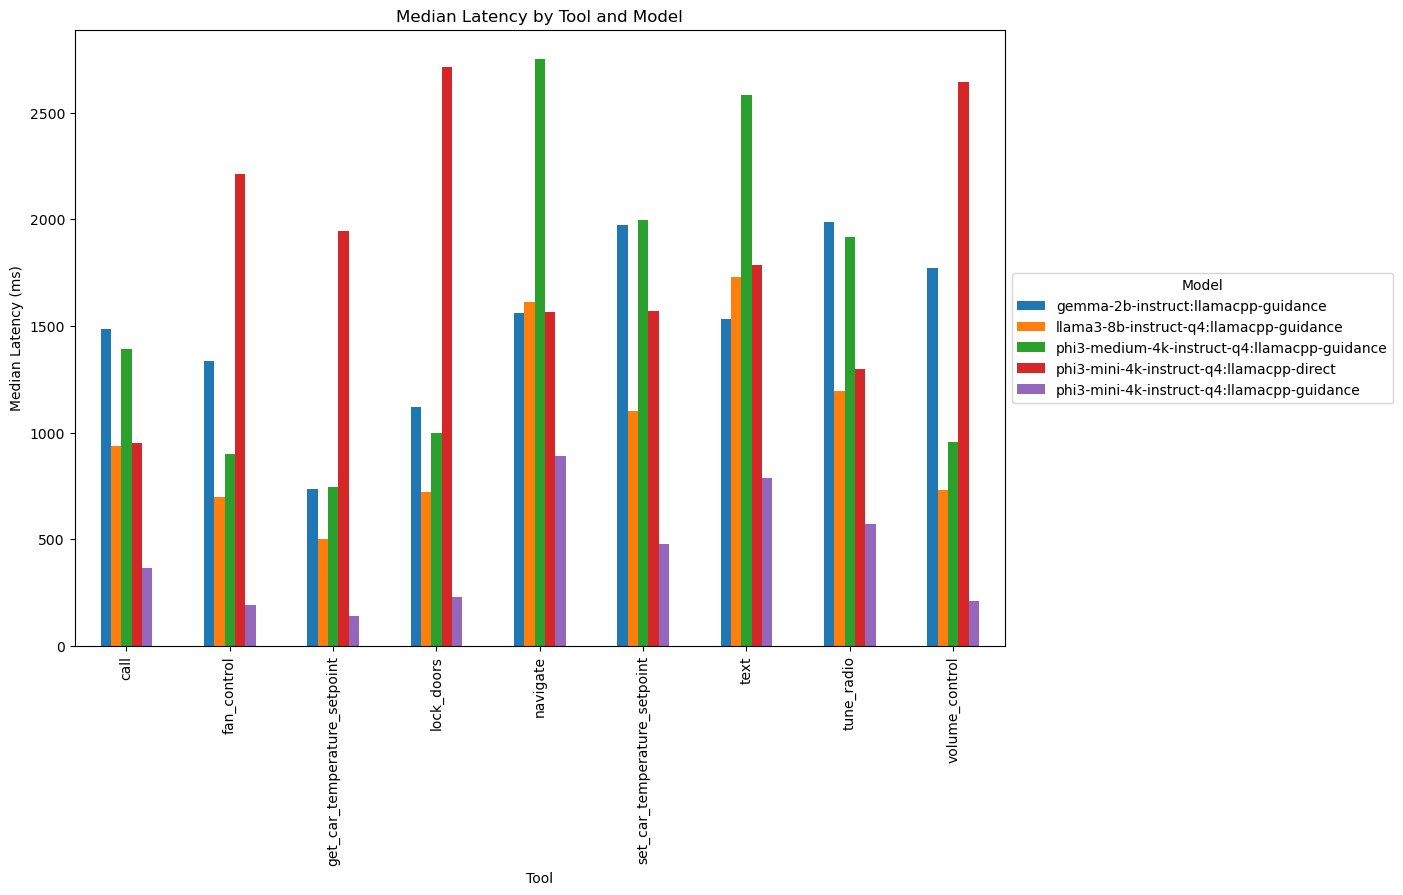

In [36]:
# Pivot the DataFrame to have models as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='model', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool and Model')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Model', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [37]:
from IPython.display import display, HTML

errors_df = df[df['errors'].apply(lambda x: len(x) > 0)]
headers = ["user", "exp f(x)", "gen f(x)", "exp params", "gen params"]

for index, row in errors_df.iterrows():
    model_name = row['model']
    tool_name = row['tool']
    errors = row['errors']

    display(HTML(f"<b>Errors analysis for {tool_name} with config {model_name}</b>"))
    
    errors_table = []
    for error in errors:
        print()
        user_input = error["user_input"]
        
        expected_function = error["expected_function"]
        generated_function = error["generated_function"]
        
        if expected_function != generated_function:
            print(f"{user_input} -> expected f(x) {expected_function} vs. generated {generated_function}")

        expected_parameters = error["expected_parameters"]
        generated_parameters = error["generated_parameters"]
        
        if expected_parameters != generated_parameters:
            print(f'"{user_input}"')
            print(f"expected params:  {expected_parameters}")
            print(f"generated params: {generated_parameters}")

    print()
        


"Please call Clara Müller"
expected params:  {'name': 'Clara Müller'}
generated params: {'name': 'Clara Muller'}




"Please text Clara Müller that I am almost there"
expected params:  {'name': 'Clara Müller', 'message': 'I am almost there'}
generated params: {'name': 'Clara M\\u00fcller', 'message': 'I am almost there'}




"Please set it to 75 degrees."
expected params:  {'temperature': 75}
generated params: {'temperature': 750.0}

"Can you make it 73 degrees?"
expected params:  {'temperature': 73}
generated params: {'temperature': 730.0}

"Can you make it 59 degrees?"
expected params:  {'temperature': 59}
generated params: {'temperature': 590.0}

"Set it at 72 degrees, thanks."
expected params:  {'temperature': 72}
generated params: {'temperature': 720.0}

"Set it at 71 degrees, thanks."
expected params:  {'temperature': 71}
generated params: {'temperature': 710.0}

"Can you make it 68 degrees?"
expected params:  {'temperature': 68}
generated params: {'temperature': 680.0}

"Please set it to 75 degrees."
expected params:  {'temperature': 75}
generated params: {'temperature': 750.0}

"Can you please set it to 65 degrees?"
expected params:  {'temperature': 65}
generated params: {'temperature': 650.0}

"Please set it to 72 degrees."
expected params:  {'temperature': 72}
generated params: {'temperature': 7


"Please call Lars"
expected params:  {'name': 'Lars'}
generated params: {'name': 'John Doe'}

"Please call Katarzyna"
expected params:  {'name': 'Katarzyna'}
generated params: {'name': 'John Doe'}

"Please call Rui Silva"
expected params:  {'name': 'Rui Silva'}
generated params: {'name': 'John Doe'}

"Please call Nils Johansson"
expected params:  {'name': 'Nils Johansson'}
generated params: {'name': 'John Smith'}

"Please call Jan Kowalski"
expected params:  {'name': 'Jan Kowalski'}
generated params: {'name': 'John Doe'}

"Please call Maja"
expected params:  {'name': 'Maja'}
generated params: {'name': 'John Doe'}

"Please call Kristina Horvat"
expected params:  {'name': 'Kristina Horvat'}
generated params: {'name': 'John Doe'}

"Please call Lars Lindberg"
expected params:  {'name': 'Lars Lindberg'}
generated params: {'name': 'John Doe'}

"Please call Lars Madsen"
expected params:  {'name': 'Lars Madsen'}
generated params: {'name': 'John Doe'}

"Please call Lars Lindberg"
expected para


Increase the fan please -> expected f(x) fan_control vs. generated tune_radio
"Increase the fan please"
expected params:  {'level': 'increase'}
generated params: {'station': 'rock'}

Decrease fan speed -> expected f(x) fan_control vs. generated tune_radio
"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: {'station': 'rock'}

Decrease fan speed -> expected f(x) fan_control vs. generated tune_radio
"Decrease fan speed"
expected params:  {'level': 'decrease'}
generated params: {'station': 'rock'}

Turn off fan -> expected f(x) fan_control vs. generated tune_radio
"Turn off fan"
expected params:  {'level': 'off'}
generated params: {'station': '<radio station>'}

Increase the fan please -> expected f(x) fan_control vs. generated tune_radio
"Increase the fan please"
expected params:  {'level': 'increase'}
generated params: {'station': 'rock'}

Turn the fan up -> expected f(x) fan_control vs. generated tune_radio
"Turn the fan up"
expected params:  {'level': 'inc


What’s the thermostat set to? -> expected f(x) get_car_temperature_setpoint vs. generated set_car_temperature_setpoint
"What’s the thermostat set to?"
expected params:  {}
generated params: {'temperature': 25.5}

What’s the thermostat set to? -> expected f(x) get_car_temperature_setpoint vs. generated set_car_temperature_setpoint
"What’s the thermostat set to?"
expected params:  {}
generated params: {'temperature': 25.5}

How hot or cold is it set to? -> expected f(x) get_car_temperature_setpoint vs. generated set_car_temperature_setpoint
"How hot or cold is it set to?"
expected params:  {}
generated params: {'temperature': 25.5}

How hot or cold is it set to? -> expected f(x) get_car_temperature_setpoint vs. generated set_car_temperature_setpoint
"How hot or cold is it set to?"
expected params:  {}
generated params: {'temperature': 25.5}

What’s the thermostat set to? -> expected f(x) get_car_temperature_setpoint vs. generated set_car_temperature_setpoint
"What’s the thermostat set t


Please unlock the doors. -> expected f(x) lock_doors vs. generated call
"Please unlock the doors."
expected params:  {'lock': 'unlock'}
generated params: {'name': 'Unlock Car Doors'}

Please unlock the doors. -> expected f(x) lock_doors vs. generated call
"Please unlock the doors."
expected params:  {'lock': 'unlock'}
generated params: {'name': 'Unlock Car Doors'}

Could you please unlock the doors? -> expected f(x) lock_doors vs. generated call
"Could you please unlock the doors?"
expected params:  {'lock': 'unlock'}
generated params: {'name': 'Unlock Car Doors'}

Please unlock the doors. -> expected f(x) lock_doors vs. generated call
"Please unlock the doors."
expected params:  {'lock': 'unlock'}
generated params: {'name': 'Unlock Car Doors'}

Can you please unlock the doors for me. -> expected f(x) lock_doors vs. generated call
"Can you please unlock the doors for me."
expected params:  {'lock': 'unlock'}
generated params: {'name': 'Unlock Car Doors'}

Could you please unlock the d


Drive to 42 O'Connell Street, Dublin, Ireland -> expected f(x) navigate vs. generated tune_radio
"Drive to 42 O'Connell Street, Dublin, Ireland"
expected params:  {'destination': "42 O'Connell Street, Dublin, Ireland"}
generated params: {'station': ' '}

Route me to 30 Strøget -> expected f(x) navigate vs. generated call
"Route me to 30 Strøget"
expected params:  {'destination': '30 Strøget'}
generated params: {'name': 'John Doe'}

Get directions to 25 Váci Street, Budapest -> expected f(x) navigate vs. generated tune_radio
"Get directions to 25 Váci Street, Budapest"
expected params:  {'destination': '25 Váci Street, Budapest'}
generated params: {'station': ' '}

Navigate to 1701 Wynkoop Street -> expected f(x) navigate vs. generated tune_radio
"Navigate to 1701 Wynkoop Street"
expected params:  {'destination': '1701 Wynkoop Street'}
generated params: {'station': '100'}

Route me to 4155 East Grant Road -> expected f(x) navigate vs. generated call
"Route me to 4155 East Grant Road"
e


"Can you change the temperature to 61 degrees?"
expected params:  {'temperature': 61}
generated params: {'temperature': 611.0}

Can you adjust it to 68 degrees? -> expected f(x) set_car_temperature_setpoint vs. generated tune_radio
"Can you adjust it to 68 degrees?"
expected params:  {'temperature': 68}
generated params: {'station': '68'}

Would you put the temperature at 67 degrees? -> expected f(x) set_car_temperature_setpoint vs. generated get_car_temperature_setpoint
"Would you put the temperature at 67 degrees?"
expected params:  {'temperature': 67}
generated params: {}

Please change it to 74 degrees for me. -> expected f(x) set_car_temperature_setpoint vs. generated tune_radio
"Please change it to 74 degrees for me."
expected params:  {'temperature': 74}
generated params: {'station': '74'}

Can you make it 61 degrees? -> expected f(x) set_car_temperature_setpoint vs. generated tune_radio
"Can you make it 61 degrees?"
expected params:  {'temperature': 61}
generated params: {'sta


Please text Johanna Schneider that I am almost there -> expected f(x) text vs. generated call
"Please text Johanna Schneider that I am almost there"
expected params:  {'name': 'Johanna Schneider', 'message': 'I am almost there'}
generated params: {'name': 'Johanna Schneider'}

Please text Klara that I am on my way -> expected f(x) text vs. generated call
"Please text Klara that I am on my way"
expected params:  {'name': 'Klara', 'message': 'I am on my way'}
generated params: {'name': 'Klara'}

Please text Julia Schmidt that I am running late -> expected f(x) text vs. generated call
"Please text Julia Schmidt that I am running late"
expected params:  {'name': 'Julia Schmidt', 'message': 'I am running late'}
generated params: {'name': 'Julia Schmidt'}

Please text Sarah that I am running behind -> expected f(x) text vs. generated call
"Please text Sarah that I am running behind"
expected params:  {'name': 'Sarah', 'message': 'I am running behind'}
generated params: {'name': 'Sarah'}

Pl


Set the volume to 3 -> expected f(x) volume_control vs. generated set_car_temperature_setpoint
"Set the volume to 3"
expected params:  {'volume': '3'}
generated params: {'temperature': 31.0}

Please adjust the volume to 3 -> expected f(x) volume_control vs. generated tune_radio
"Please adjust the volume to 3"
expected params:  {'volume': '3'}
generated params: {'station': '<|im_end|>}}\n\nPlease note that the volume adjustment is only applicable when the '}

Can you set the volume to 3 -> expected f(x) volume_control vs. generated set_car_temperature_setpoint
"Can you set the volume to 3"
expected params:  {'volume': '3'}
generated params: {'temperature': 31.0}

Set the volume to 3 -> expected f(x) volume_control vs. generated set_car_temperature_setpoint
"Set the volume to 3"
expected params:  {'volume': '3'}
generated params: {'temperature': 31.0}

Set the volume to 3 -> expected f(x) volume_control vs. generated set_car_temperature_setpoint
"Set the volume to 3"
expected params:  {


"Please call Angela Reed"
expected params:  {'name': 'Angela Reed'}
generated params: [{'name': 'name', 'value': 'Angela Reed'}]

"Please call Louise Dubois"
expected params:  {'name': 'Louise Dubois'}
generated params: [{'name': 'name', 'value': 'Louise Dubois'}]

"Please call Alina Morozova"
expected params:  {'name': 'Alina Morozova'}
generated params: [{'name': 'name', 'value': 'Alina Morozova'}]

"Please call Marie Dupont"
expected params:  {'name': 'Marie Dupont'}
generated params: [{'name': 'name', 'value': 'Marie Dupont'}]

"Please call Timothy Phillips"
expected params:  {'name': 'Timothy Phillips'}
generated params: [{'name': 'name', 'value': 'Timothy Phillips'}]

"Please call Michelle Brooks"
expected params:  {'name': 'Michelle Brooks'}
generated params: [{'name': 'name', 'value': 'Michelle Brooks'}]

"Please call Alina Morozova"
expected params:  {'name': 'Alina Morozova'}
generated params: [{'name': 'name', 'value': 'Alina Morozova'}]

"Please call Oliver Klein"
expected

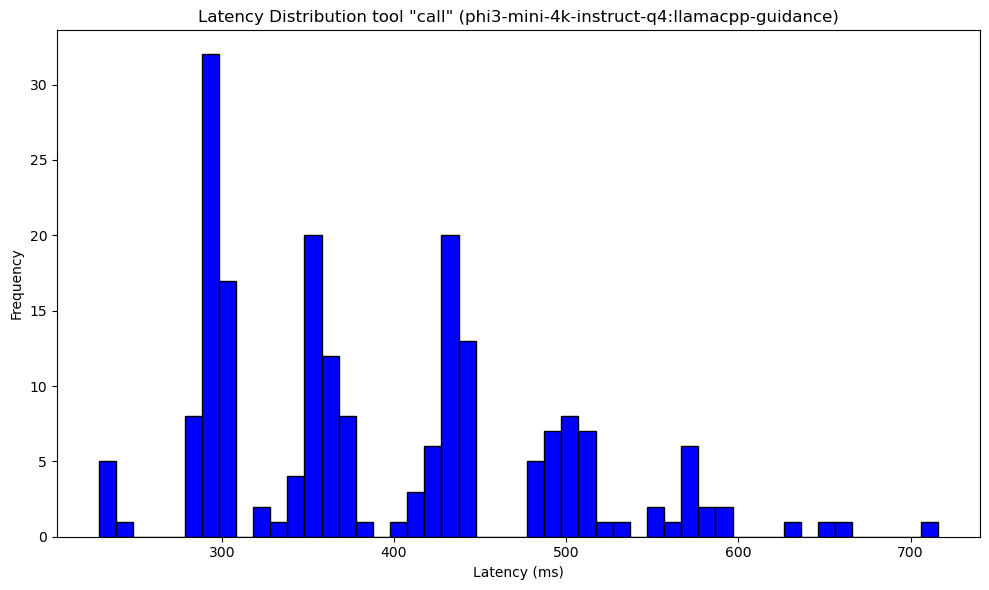

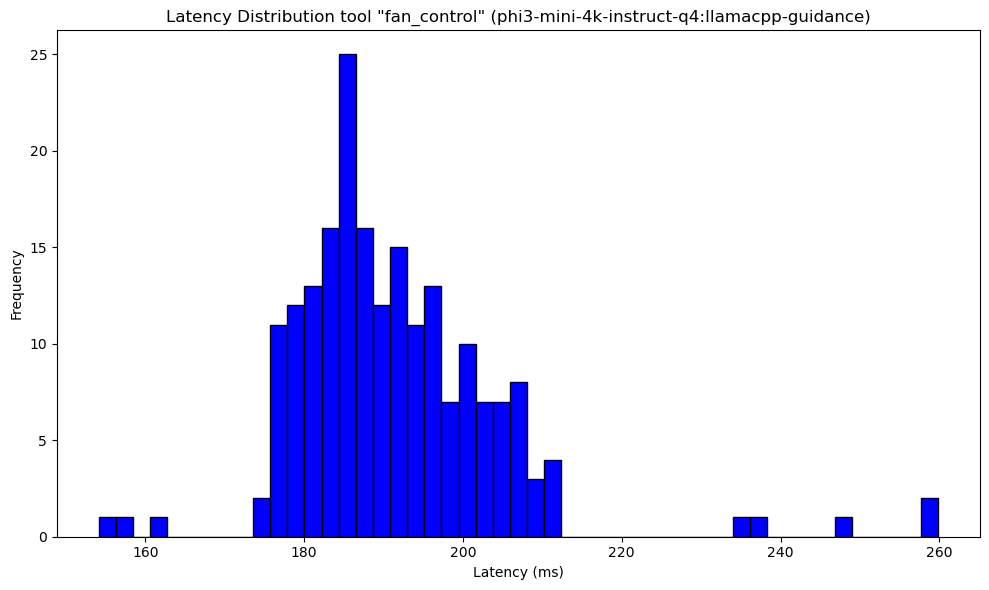

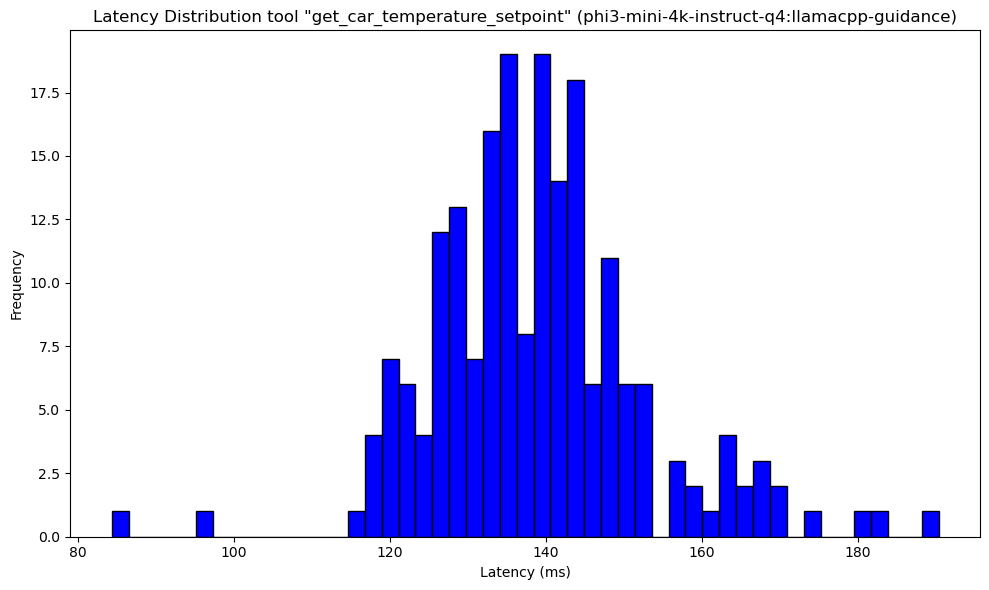

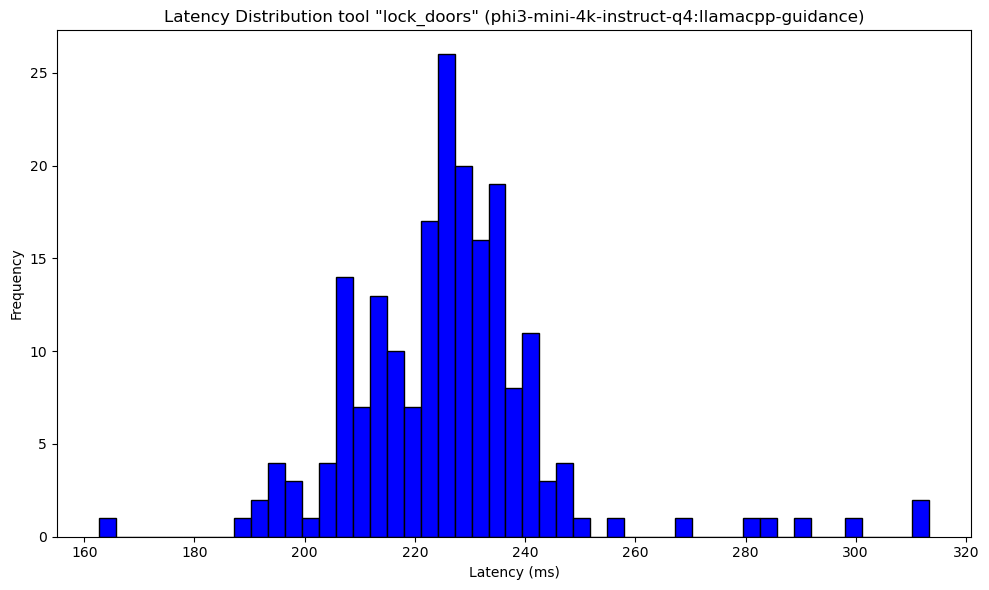

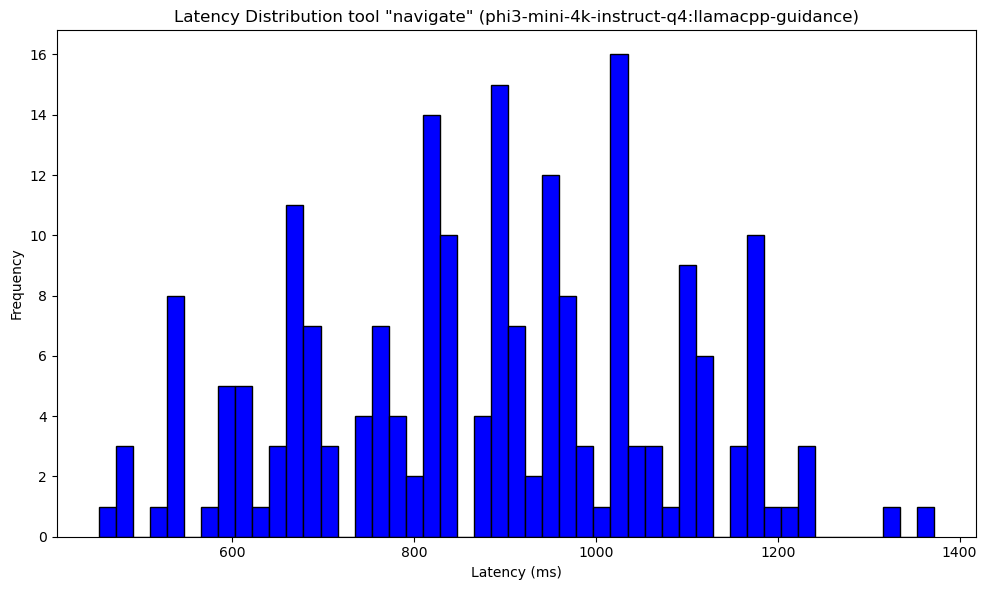

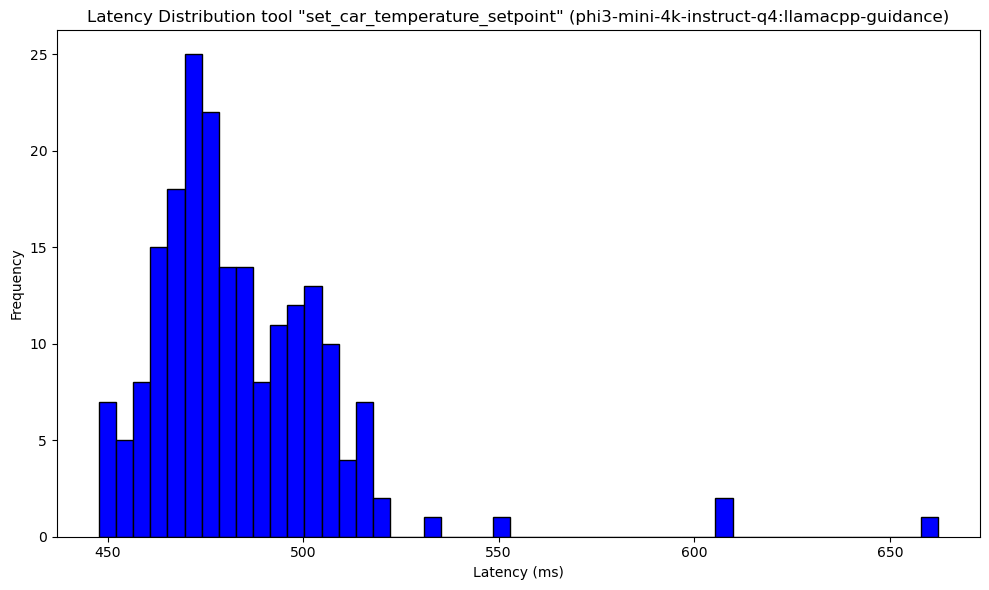

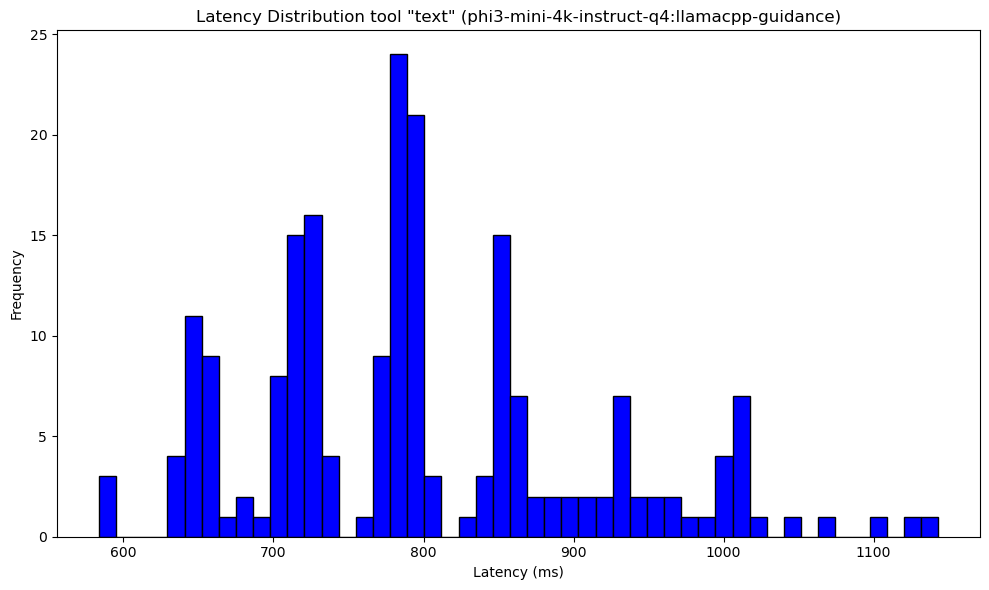

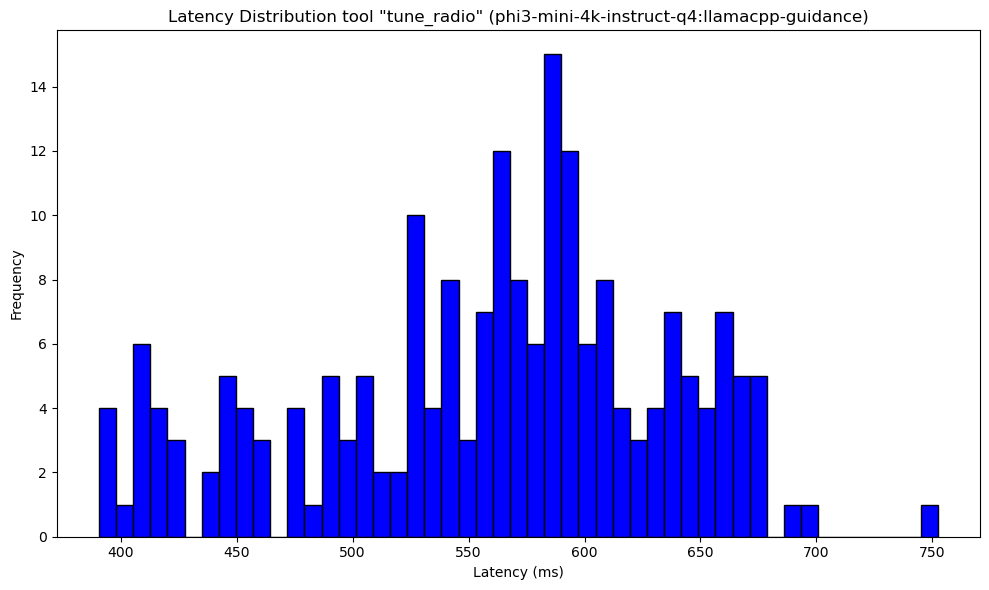

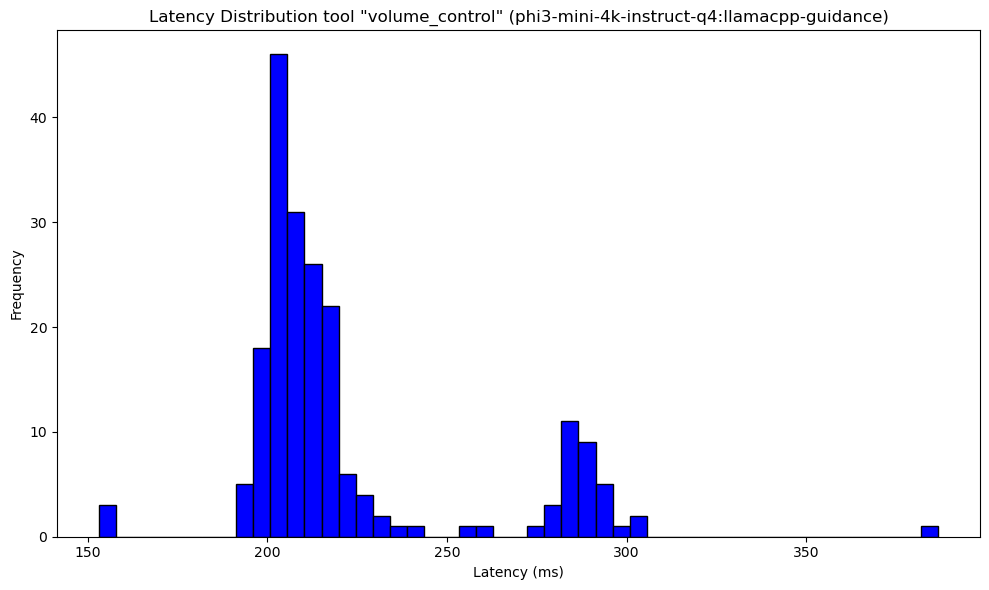

In [42]:
import numpy as np
import matplotlib.pyplot as plt

# Ensure plots are displayed inline
%matplotlib inline

llamacpp_guidance_df = df[df['model'].apply(lambda model: model == "phi3-mini-4k-instruct-q4:llamacpp-guidance")]

for row in llamacpp_guidance_df.iterrows():
    config_name = row[1]['model']
    tool_name = row[1]['tool']
    latencies = row[1]['latencies']

    # Create bins for the histogram
    min_latency = min(latencies)
    max_latency = max(latencies)
    bins = np.linspace(min_latency, max_latency, 50)
    
    # Plotting the latency distribution
    plt.figure(figsize=(10, 6))
    plt.hist(latencies, bins=bins, edgecolor='black', color='blue')
    
    plt.title(f'Latency Distribution tool "{tool_name}" ({config_name})')
    plt.xlabel('Latency (ms)')
    plt.ylabel('Frequency')

    # Adjust layout to ensure no overlapping elements
    plt.tight_layout()
    
    plt.show()

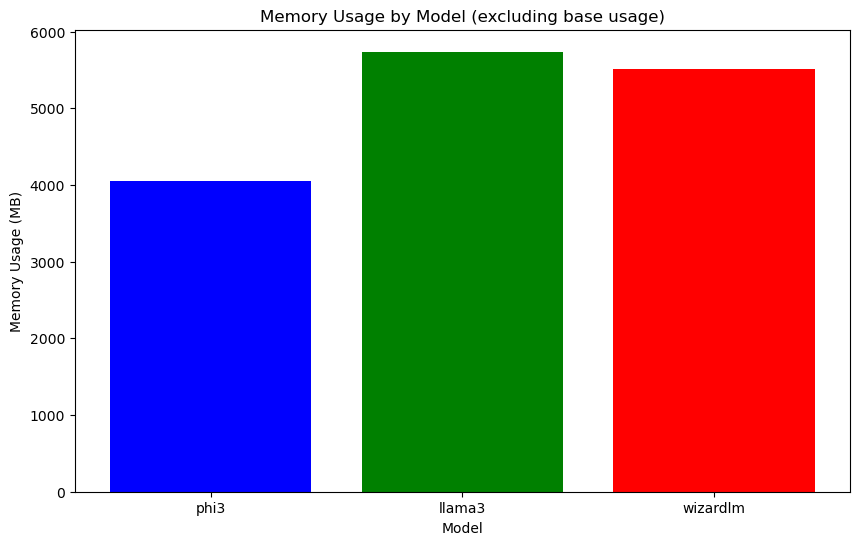

In [22]:
# Base memory usage
base_memory_usage = 1889 # MB

# Compute gross memory measurements with nvidia-smi minus base usage
phi3_memory_usage = 5935 - base_memory_usage # MB
llama3_memory_usage = 7626 - base_memory_usage # MB
wizardlm_memory_usage = 7403 - base_memory_usage # MB

# Data for plotting
models = ['phi3', 'llama3', 'wizardlm']
memory_usage = [phi3_memory_usage, llama3_memory_usage, wizardlm_memory_usage]

# Plotting the bar chart
plt.figure(figsize=(10, 6))
plt.bar(models, memory_usage, color=['blue', 'green', 'red'])

plt.title('Memory Usage by Model (excluding base usage)')
plt.xlabel('Model')
plt.ylabel('Memory Usage (MB)')
plt.show()

In [23]:
with open('results/tool-count-eval-m1-max.json', 'r') as file:
    data = json.load(file)

In [24]:
records = []

for tool_count, tools in data.items():
    for tool, metrics in tools.items():
        records.append({
            'tool_count': tool_count,
            'tool': tool,
            'median_latency': metrics['median_latency'],
            'pass_percentage': metrics['pass_percentage'],
        })

df = pd.DataFrame(records)

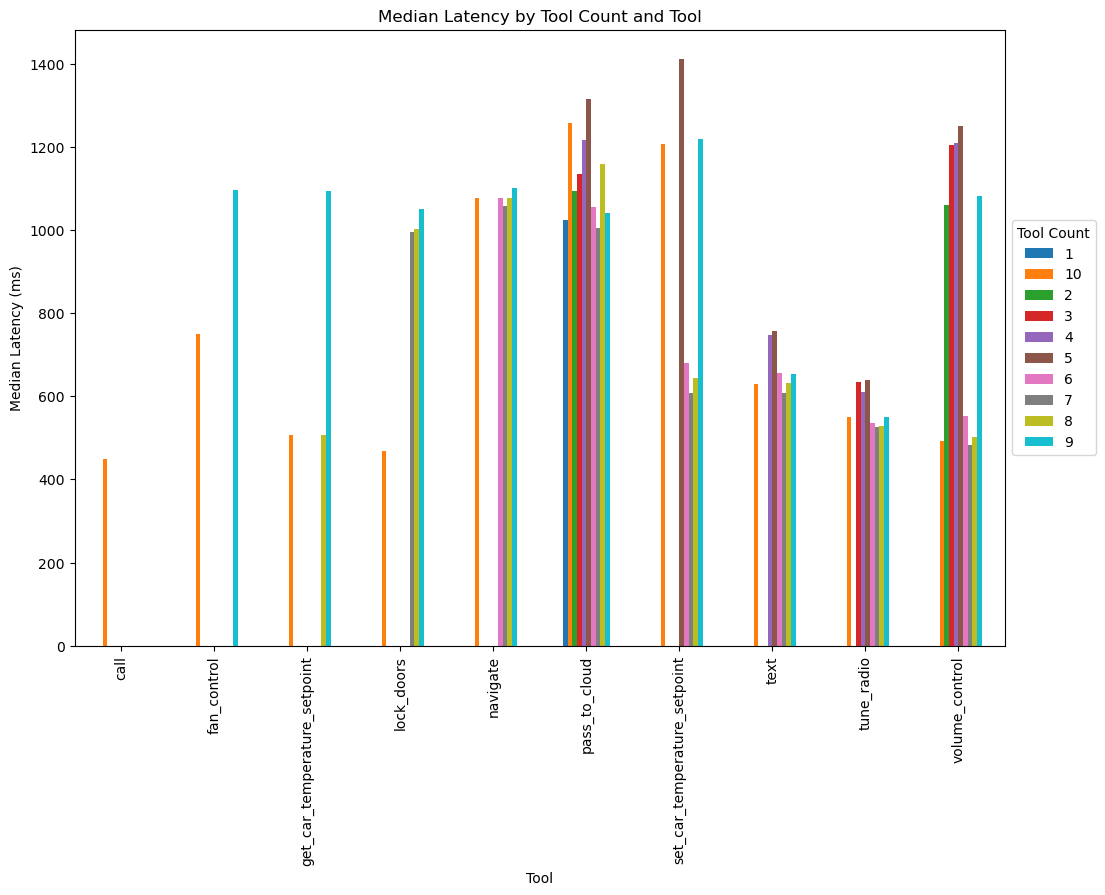

In [25]:
# Pivot the DataFrame to have tool counts as columns and tools as rows
pivot_df = df.pivot(index='tool', columns='tool_count', values='median_latency')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Median Latency by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Median Latency (ms)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

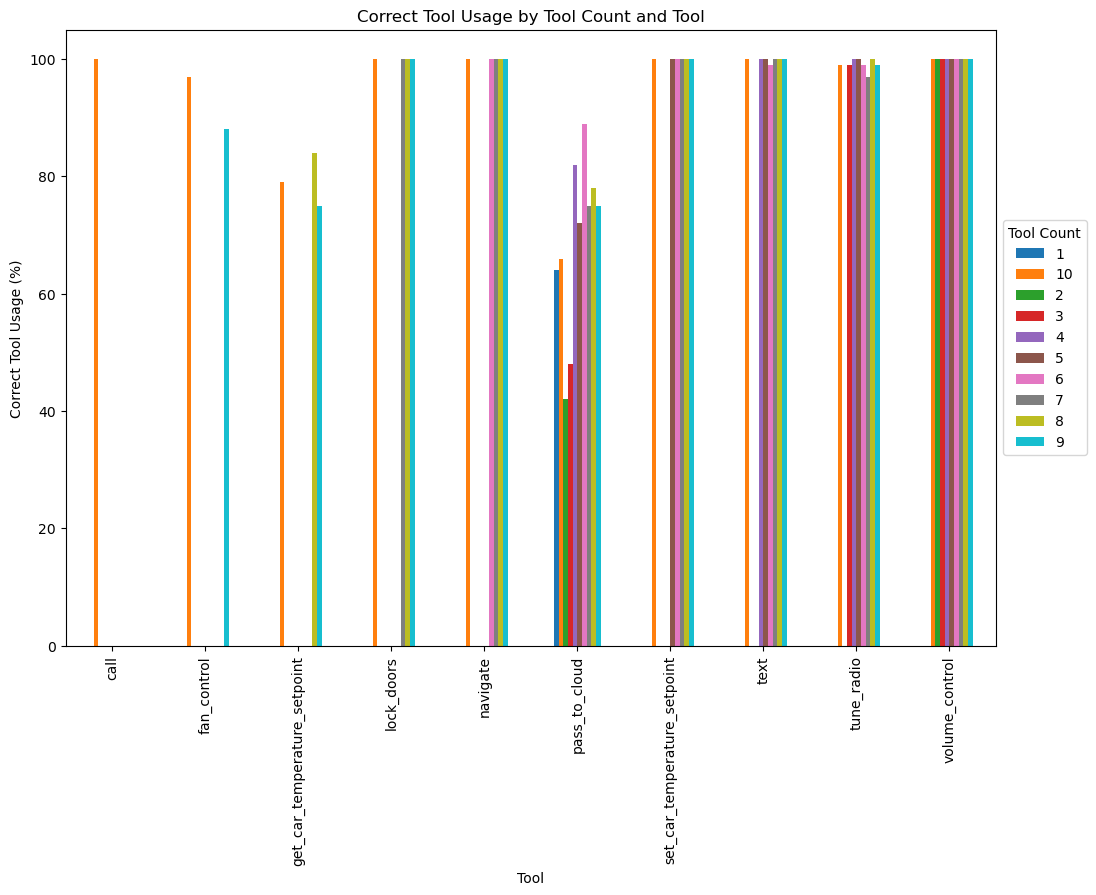

In [26]:
pivot_df = df.pivot(index='tool', columns='tool_count', values='pass_percentage')

# Plotting the data
pivot_df.plot(kind='bar', figsize=(12, 8))

plt.title('Correct Tool Usage by Tool Count and Tool')
plt.xlabel('Tool')
plt.ylabel('Correct Tool Usage (%)')
plt.legend(title='Tool Count', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.show()

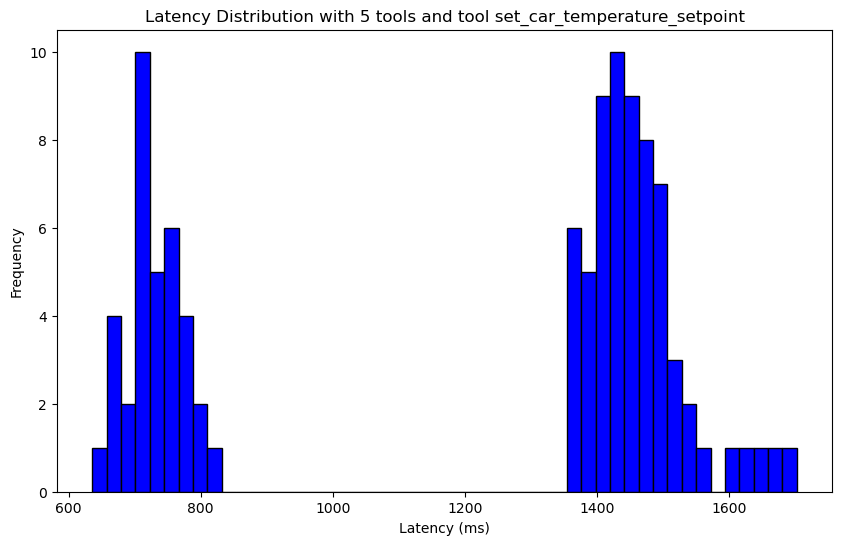

In [27]:
import numpy as np
import matplotlib.pyplot as plt

tool_count = '5'
tool_name = 'set_car_temperature_setpoint'

five_tool_count = data[tool_count]
latencies = five_tool_count[tool_name]['latencies']

# Create bins for the histogram
min_latency = min(latencies)
max_latency = max(latencies)
bins = np.linspace(min_latency, max_latency, 50)

# Plotting the latency distribution
plt.figure(figsize=(10, 6))
plt.hist(latencies, bins=bins, edgecolor='black', color='blue')

plt.title(f'Latency Distribution with {tool_count} tools and tool {tool_name}')
plt.xlabel('Latency (ms)')
plt.ylabel('Frequency')
plt.show()

In [28]:
# Are there user inputs that are more likely to fail?
# How does hardware effect latency (4800 vs. M1 Max vs M4)?